C:\Users\athit\miniconda3\envs\jupyter_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Base Model Test Accuracy: 0.8156
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       105
           1       0.81      0.73      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179



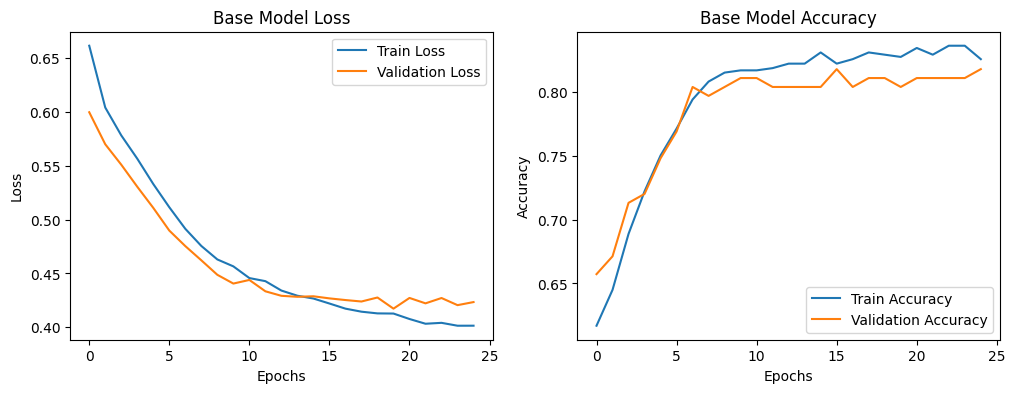

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
L2 Regularization Test Accuracy: 0.8156
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       105
           1       0.82      0.72      0.76        74

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179



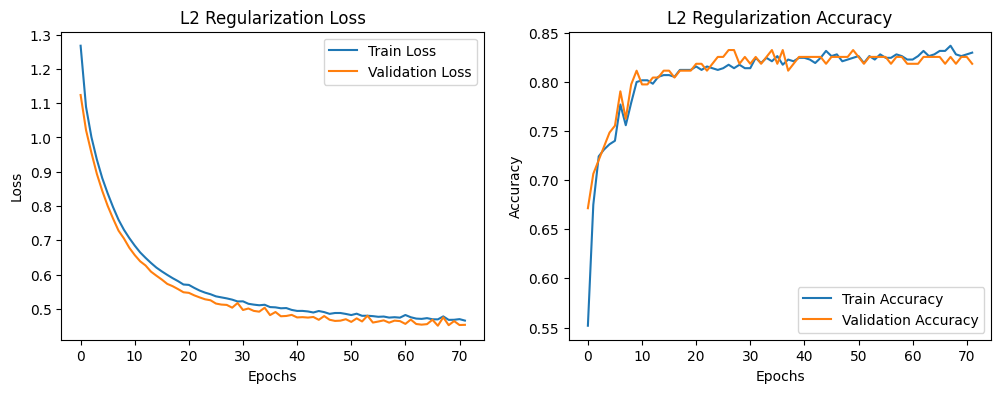

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Dropout Test Accuracy: 0.8212
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       105
           1       0.81      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



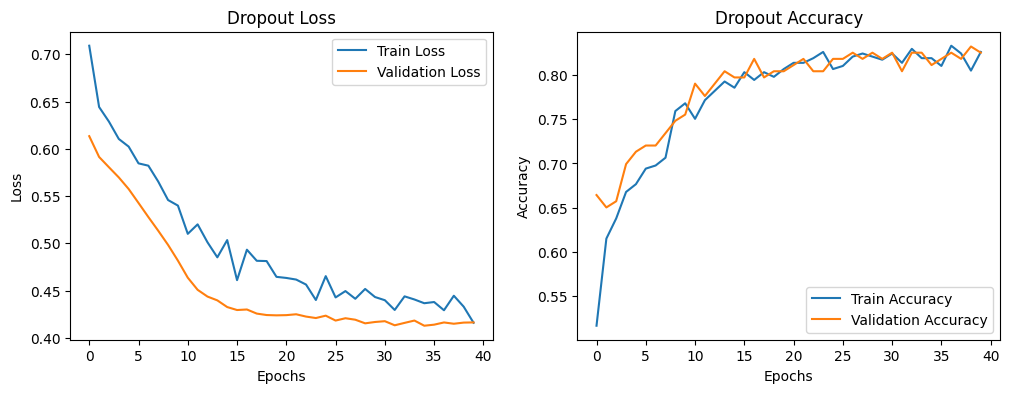

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Combined Regularization Test Accuracy: 0.8101
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       105
           1       0.79      0.73      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



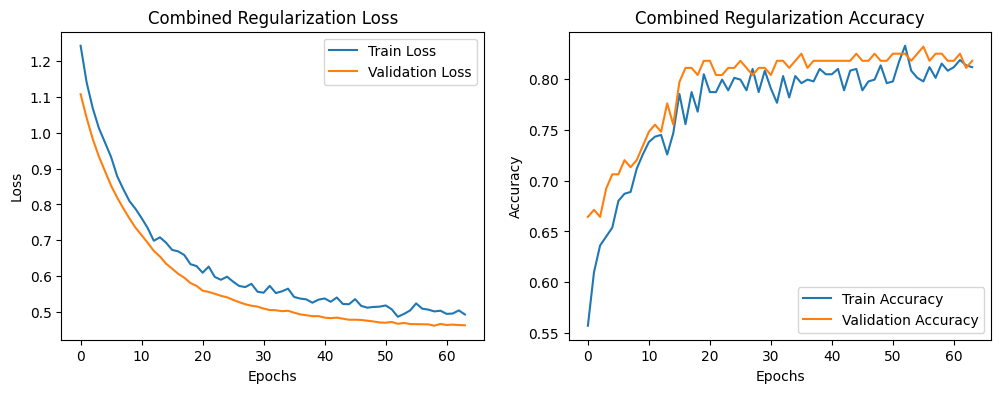

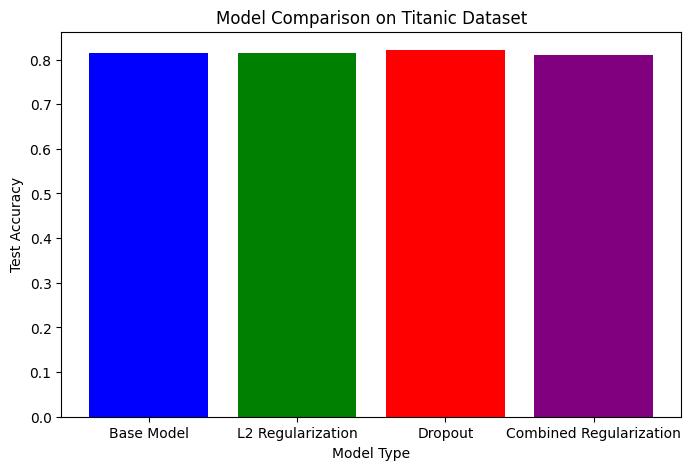

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Load the Titanic dataset from seaborn
data = sns.load_dataset("titanic")

# Drop irrelevant columns
data = data.drop(columns=["who", "deck", "embark_town", "alive", "adult_male", "class"], errors="ignore")

# Handle missing values
data["age"] = data["age"].fillna(data["age"].median())
data["embarked"] = data["embarked"].fillna(data["embarked"].mode()[0])
data["fare"] = data["fare"].fillna(data["fare"].median())

# Convert categorical variables
data = pd.get_dummies(data, columns=["sex", "embarked"], drop_first=True)

# Drop rows with missing target values
data = data.dropna(subset=["survived"])

# Define features and target
X = data.drop(columns=["survived"])
y = data["survived"]

# Standardize numerical features
scaler = StandardScaler()
numerical_cols = ["age", "fare"]
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model functions
def build_model(l2_lambda=0.0, dropout_rate=0.0):
    model = Sequential([
        Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(32, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train and evaluate function
def train_and_evaluate(model_name, model):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping], verbose=0
    )
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    y_pred = (model.predict(X_test).flatten() >= 0.5).astype(int)
    print(f"{model_name} Test Accuracy: {test_accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    return test_accuracy

# Train models and compare
models = {
    "Base Model": build_model(),
    "L2 Regularization": build_model(l2_lambda=0.01),
    "Dropout": build_model(dropout_rate=0.3),
    "Combined Regularization": build_model(l2_lambda=0.01, dropout_rate=0.3)
}

results = {}
for model_name, model in models.items():
    results[model_name] = train_and_evaluate(model_name, model)

# Compare results
plt.figure(figsize=(8, 5))
plt.bar(results.keys(), results.values(), color=['blue', 'green', 'red', 'purple'])
plt.xlabel("Model Type")
plt.ylabel("Test Accuracy")
plt.title("Model Comparison on Titanic Dataset")
plt.show()
